Epoch 1/20


2025-02-04 01:23:54.080598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-02-04 01:23:54.109080: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6/6 [==============================] - 8s 1s/step - loss: 2.3300 - accuracy: 0.3438 - val_loss: 1.4339 - val_accuracy: 0.3500
Epoch 2/20
6/6 [==============================] - 7s 1s/step - loss: 0.9454 - accuracy: 0.6438 - val_loss: 0.3619 - val_accuracy: 0.8250
Epoch 3/20
6/6 [==============================] - 5s 895ms/step - loss: 0.4806 - accuracy: 0.8188 - val_loss: 0.2359 - val_accuracy: 0.9250
Epoch 4/20
6/6 [==============================] - 6s 952ms/step - loss: 0.2438 - accuracy: 0.9125 - val_loss: 0.0750 - val_accuracy: 1.0000
Epoch 5/20
6/6 [==============================] - 6s 957ms/step - loss: 0.1204 - accuracy: 0.9625 - val_loss: 0.0615 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 6s 931ms/step - loss: 0.0972 - accuracy: 0.9688 - val_loss: 0.0346 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 6s 916ms/step - loss: 0.0680 - accuracy: 0.9937 - val_loss: 0.0186 - val_accuracy: 1.0000
Epoch 8/20
6/6 [=====================

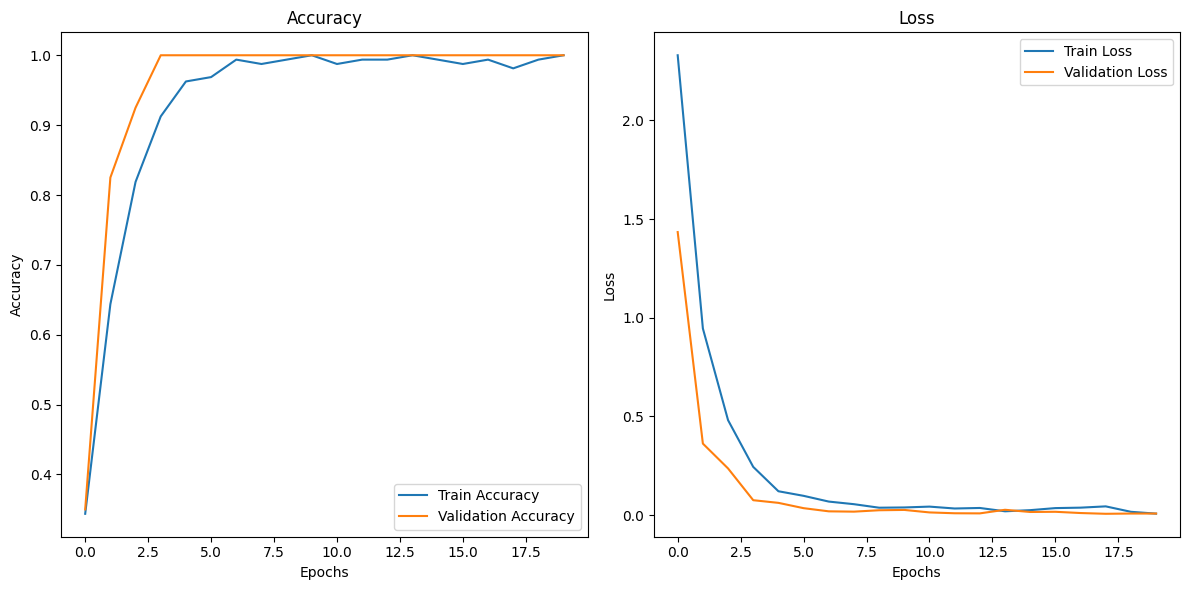

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Path to dataset
DATASET_PATH = 'dataset'

# Initialize data and labels
data = []
labels = []

# Mapping user IDs to names
user_map = {
    "1": "Tanzeem",
    "2": "Nayeem",
    "3": "Raiyan",
    "4": "Alvee"
}

# Load images and labels
for image_name in os.listdir(DATASET_PATH):
    image_path = os.path.join(DATASET_PATH, image_name)

    if image_name.startswith("User") and image_name.endswith(".jpg"):
        user_id = image_name.split('.')[1]  # Extract the user ID (e.g., "User.1.1.jpg" → "1")

        if user_id in user_map:
            label_index = int(user_id) - 1  # Convert to zero-based index

            # Load and preprocess image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            image = preprocess_input(image)
            image = img_to_array(image)

            data.append(image)
            labels.append(label_index)

# Convert to NumPy arrays
data = np.array(data, dtype='float32')
labels = np.array(labels)

# One-hot encode labels
num_classes = len(user_map)
labels = to_categorical(labels, num_classes)

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Build the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
datagen.fit(x_train)

history = model.fit(datagen.flow(x_train, y_train, batch_size=30), validation_data=(x_test, y_test), epochs=20)

# Save the trained model
model.save('resnet_face_recognition_model.h5')
print("Model saved as 'resnet_face_recognition_model.h5'")

# Plot training performance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
import os
import cv2
import numpy as np
from datetime import datetime
import xlwt
from xlrd import open_workbook
from xlutils.copy import copy
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load Haarcascade for real-time face recognition
face_cascade = cv2.CascadeClassifier('model/haarcascade_frontalface_default.xml')

# Load trained model
model = load_model('resnet_face_recognition_model.h5')
print("Model loaded successfully.")

# Mapping user IDs to names
user_map = {
    "1": "Tanzeem",
    "2": "Nayeem",
    "3": "Raiyan",
    "4": "Alvee"
}

# Attendance sheet folder
ATTENDANCE_FOLDER = 'attendance_sheet'
os.makedirs(ATTENDANCE_FOLDER, exist_ok=True)

# Get today's date for the attendance sheet
today_date = datetime.now().strftime("%Y-%m-%d")
attendance_file = os.path.join(ATTENDANCE_FOLDER, f"{today_date}.xls")

# Function to log attendance
def log_attendance(name):
    if os.path.exists(attendance_file):
        rb = open_workbook(attendance_file)
        sheet = rb.sheet_by_index(0)  # Read the first sheet
        num_rows = sheet.nrows  # Get the number of rows
        wb = copy(rb)  # Copy the workbook
        sheet = wb.get_sheet(0)  # Get the first sheet (writable)
    else:
        wb = xlwt.Workbook()
        sheet = wb.add_sheet('Attendance')
        sheet.write(0, 0, "Name")
        sheet.write(0, 1, "Status")
        num_rows = 1  # Start writing from row 1

    sheet.write(num_rows, 0, name)
    sheet.write(num_rows, 1, "Present")
    wb.save(attendance_file)
    print(f"Attendance logged for {name}")

# Capture video
cap = cv2.VideoCapture(0)
recognized_users = set()  # Store recognized users to avoid duplicate logs

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=6, minSize=(30, 30))

    for (x, y, w, h) in faces:
        roi = frame[y:y + h, x:x + w]
        roi = cv2.resize(roi, (224, 224))
        roi = preprocess_input(roi.astype('float32'))
        roi = np.expand_dims(roi, axis=0)

        preds = model.predict(roi)
        predicted_class = np.argmax(preds)
        confidence = np.max(preds) * 100

        label = user_map.get(str(predicted_class + 1), "Unknown")

        # Log attendance only once per user per session
        if label != "Unknown" and label not in recognized_users:
            log_attendance(label)
            recognized_users.add(label)

        # Draw bounding box and text
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, f"{label}: {confidence:.2f}%", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        break  # Ensure only one face is processed at a time

    cv2.imshow('Face Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Model loaded successfully.
1/1 [==============================] - 1s 551ms/step
Attendance logged for Raiyan


2025-02-04 01:26:14.868 python[14923:404558] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-04 01:26:14.868 python[14923:404558] +[IMKInputSession subclass]: chose IMKInputSession_Modern


1/1 [==============================] - 0s 57ms/step
Attendance logged for Nayeem
1/1 [==============================] - 0s 51ms/step
Attendance logged for Alvee
1/1 [==============================] - 0s 49ms/step
